## YAMnet classification by segmentation | initial dataset training and testing

In [1]:
%load_ext autoreload
%autoreload 2


import tensorflow as tf
from tensorflow  import keras
import tensorflow_hub as hub
import numpy as np

import librosa 
from util import WavDataset
import matplotlib.pyplot as plt

import h5py
from pathlib import Path
from config import INTERMEDIATE, MODEL_DIR
import pickle

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Data
- all 5 second overlapping chunks have been pregenerated under ../output/intermediate/train.hdf5 (untracked on github).
- YAMnet produces a 1024-long feature vector per 0.96s windows with a 0.48s hop. Thusly 10 frames are predicted per chunk
- labels encoded as binary frame-wise time steps (4 signal classes)

In [2]:
hdf5_dataset = h5py.File(INTERMEDIATE / 'train.hdf5', 'r')
RANDOM_CHUNKS = np.array(hdf5_dataset)
np.random.seed(0) 
np.random.shuffle(RANDOM_CHUNKS)
with open("./logs/chunk_order.pkl", "wb") as f:
        pickle.dump(RANDOM_CHUNKS, f)

In [3]:
X_shape = (10, 1024)
Y_shape = (10, 4)

def chunk_generator():
    for chunk in RANDOM_CHUNKS:
        chunk_group = hdf5_dataset[chunk]
        yield (
            np.array(chunk_group['X']), 
            np.array(chunk_group['Y']).T) 

raw_dataset = tf.data.Dataset.from_generator(
    chunk_generator, output_signature=(
        tf.TensorSpec(shape=X_shape, dtype=tf.float32),
        tf.TensorSpec(shape=Y_shape, dtype=tf.bool)))

# test
for s in raw_dataset.take(32):
    X, Y = s
    print(np.array(X).sum(), np.array(Y).sum(), end="\t\t")

print(X.shape, Y.shape)

2024-09-14 00:27:36.790530: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


458.73566 0		594.2076 0		746.2246 0		531.56323 0		657.0123 0		626.8448 0		664.3427 4		531.1446 0		777.21875 0		763.9229 0		493.90265 0		692.4295 0		566.7892 0		554.7632 0		578.3624 0		545.44275 0		787.87085 0		471.79166 0		701.3546 0		568.9809 0		637.3032 3		641.09607 0		561.34283 0		594.9181 0		801.41156 0		740.50226 0		781.42566 0		628.4475 0		667.9726 0		725.094 0		635.2217 0		614.97064 0		(10, 1024) (10, 4)


In [4]:
n_chunks =  133921 

# test
test_cut = int(n_chunks * 0.8)
train_valid_dataset = raw_dataset.take(test_cut)
test_dataset = raw_dataset.skip(test_cut)

# validation
valid_cut = int(test_cut * 0.8) 
train_dataset = train_valid_dataset.take(valid_cut)
validation_dataset = train_valid_dataset.skip(valid_cut)

print(test_cut, valid_cut)

107136 85708


## Training & Evaluation
Using a simple DNN against the embeddings (** check??)

In [5]:
from keras.layers import Input, Dense, BatchNormalization
# import tensorflow_addons as tfa
from functools import partial
from keras import metrics

def create_model(output_bias=None) -> keras.Model:
    default_dense =  partial(Dense, activation='selu', # self normalizing
                             kernel_initializer=keras.initializers.LecunNormal(seed=0)
                            ) # kernel_regularizer ?
    
    # simple DNN head for YAMnet embeddings
    return keras.Sequential(
        [
            Input(shape=(10, 1024)),
            default_dense(512), 
            default_dense(256),
            default_dense(128),
            default_dense(64), 
            Dense(4, activation='sigmoid', 
                  bias_initializer=output_bias) # correct this 
        ]
    )

def compile(model):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  
        metrics=[
            metrics.Recall(thresholds=0.5),
            metrics.Precision(thresholds=0.5),
            metrics.AUC(),
        ]
    )

model = create_model()
compile(model)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10, 512)           524800    
                                                                 
 dense_1 (Dense)             (None, 10, 256)           131328    
                                                                 
 dense_2 (Dense)             (None, 10, 128)           32896     
                                                                 
 dense_3 (Dense)             (None, 10, 64)            8256      
                                                                 
 dense_4 (Dense)             (None, 10, 4)             260       
                                                                 
Total params: 697,540
Trainable params: 697,540
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 133921 chunks
# 4185 batches

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import pandas as pd

class IncrementallySavedCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_dir):
        self.checkpoint_dir = checkpoint_dir
    
    def on_epoch_end(self, epoch, logs=None):
        checkpoint_path = Path(self.checkpoint_dir) / f'model_epoch_{epoch+1}.ckpt'
        self.model.save_weights(checkpoint_path)
        print(f"Saved checkpoint for epoch {epoch+1} at {checkpoint_path}")


def train(model, model_dir, batch, epochs, stopping_patience=5, 
          stopping_moniter='val_auc', **kwargs):
    
    model_dir.mkdir(exist_ok=True)
    
    log_dir = model_dir / "logs" / "fit"
    log_dir.mkdir(exist_ok=True)
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    
    checkpoint_path = model_dir / "training"
    Path(checkpoint_path).mkdir(exist_ok=True)  
    cp_callback = IncrementallySavedCheckpoint(
        checkpoint_path, filepath=checkpoint_path, save_weights_only=True, verbose=1  
    )
    
    es_checkpoint = EarlyStopping(
        monitor=stopping_moniter,
        patience=stopping_patience,
        restore_best_weights=True,
    )
    
    # fit
    return model.fit(
        train_dataset.batch(batch).prefetch(tf.data.AUTOTUNE), 
        validation_data=validation_dataset.batch(batch).prefetch(tf.data.AUTOTUNE),
        epochs=epochs, 
        verbose=2,
        callbacks=[tensorboard_callback, cp_callback, es_checkpoint],
        **kwargs
    )
    

history = train(model, model_dir= MODEL_DIR / "50e_initial_ds", epochs=50, batch=32)
df = pd.DataFrame(history.history)
df.to_csv("logs/history.csv")
model.save(model_dir / 'model.keras')

/4185 (per epoch)
Epoch 1/50

Epoch 00001: saving model to /home/ethan/working/acoustic-AL/models/50e_initial_ds/training/model.ckpt
2679/2679 - 1047s - loss: 0.0079 - recall_2: 0.0073 - precision_2: 0.0461 - auc_1: 0.6827 - accuracy: 0.5232 - val_loss: 0.0076 - val_recall_2: 0.1560 - val_precision_2: 0.4913 - val_auc_1: 0.7651 - val_accuracy: 0.7889 - 1047s/epoch - 391ms/step
Epoch 2/50

Epoch 00002: saving model to /home/ethan/working/acoustic-AL/models/50e_initial_ds/training/model.ckpt
2679/2679 - 835s - loss: 0.0069 - recall_2: 0.0322 - precision_2: 0.5061 - auc_1: 0.7313 - accuracy: 0.5865 - val_loss: 0.0071 - val_recall_2: 0.1321 - val_precision_2: 0.6636 - val_auc_1: 0.7417 - val_accuracy: 0.8357 - 835s/epoch - 312ms/step
Epoch 3/50

Epoch 00003: saving model to /home/ethan/working/acoustic-AL/models/50e_initial_ds/training/model.ckpt
2679/2679 - 1311s - loss: 0.0065 - recall_2: 0.0545 - precision_2: 0.5660 - auc_1: 0.7559 - accuracy: 0.5720 - val_loss: 0.0070 - val_recall_2: 0

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/home/ethan/working/acoustic-AL/models/50e_initial_ds/logs

In [6]:
# get model from last checkpoint (should be ~E18 -> overfit)
model = create_model()
load_status = model.load_weights("/home/ethan/working/acoustic-AL/models/50e_initial_ds/training/model.ckpt")
load_status.expect_partial() 
compile(model)

In [7]:
y_true = []
y_pred = []

# get test ds predictions
for batch_X, batch_y in test_dataset.batch(32).prefetch(tf.data.AUTOTUNE):
    predictions = model(batch_X, training=False)
    y_true.extend(batch_y.numpy())
    y_pred.extend(predictions.numpy()) 

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [21]:
y_true_flat = y_true.reshape(-1, 4)
y_pred_flat = y_pred.reshape(-1, 4)

labels = [ "fast_trill_6khz", "nr_syllable_3khz", "triangle_3khz", "upsweep_500hz"]

# unbalanced
for i, label in enumerate(labels):
    print(f'average class probability of [{label}]: {y_true_flat[:, i].mean()}')

average class probability of [fast_trill_6khz]: 0.0015493746499906664
average class probability of [nr_syllable_3khz]: 0.0017621803248086616
average class probability of [triangle_3khz]: 0.0006832182191525108
average class probability of [upsweep_500hz]: 0.0008026880716819116


In [14]:
# what do the labels look like
annotated = [(y, yp) for (y, yp) in zip(y_true, y_pred) if y.any()] 
for chunks in annotated[:20]:
    annotated_chunk, annotated_chunk_pred = chunks
    if annotated_chunk.any():
        print(annotated_chunk) 
        print(annotated_chunk_pred)
        print('\n')

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False  True False False]
 [False  True False False]
 [False  True False False]
 [False  True False False]
 [False  True False False]]
[[1.17322803e-03 9.48876143e-04 1.26880877e-05 6.62854582e-05]
 [7.14868307e-04 7.50273466e-04 2.21328810e-06 4.79502378e-05]
 [1.23044848e-03 5.79890609e-03 3.47064124e-05 1.55746937e-04]
 [3.91898084e-07 4.77123285e-06 2.23981930e-10 1.97947756e-07]
 [2.57134438e-04 1.31527822e-05 8.13141105e-06 1.10780347e-05]
 [3.00061703e-03 1.55311525e-02 4.25904989e-04 7.82132149e-04]
 [5.50460815e-03 2.66017675e-01 1.37954950e-03 7.09498418e-05]
 [1.61024928e-03 7.90052295e-01 1.86830759e-04 2.65663220e-06]
 [5.02476096e-03 3.01339924e-01 1.18911266e-03 5.55748920e-05]
 [7.24053383e-03 1.76751554e-01 2.15676427e-03 1.47938728e-04]]


[[False  True False False]
 [False  True False False]
 [False  True False False]
 [False  True F

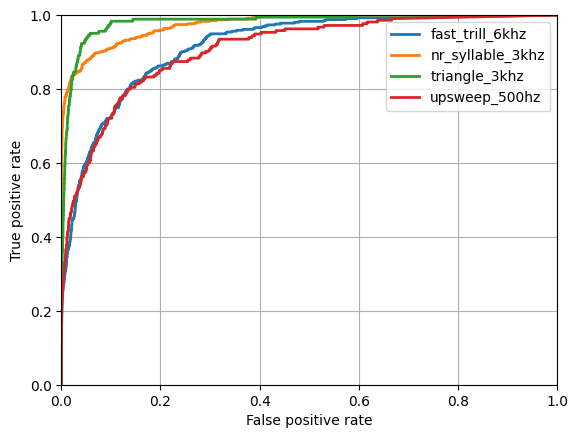

In [26]:
from sklearn.metrics import roc_curve

# PR curve
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid(True)

for i, label in enumerate(labels):
    plot_roc(labels, y_true_flat[:, i], y_pred_flat[:, i])

plt.legend(labels) 
plt.show() 

## Visualization

label counts = [4 0 0 0]


/tmp/ipykernel_6010/2117974691.py:41: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  S = librosa.power_to_db(S, ref=np.max)


failure
label counts = [3 0 0 0]
failure
label counts = [5 0 0 0]
failure
label counts = [2 0 0 0]
failure
label counts = [2 0 0 0]
failure
label counts = [0 4 0 0]
failure
label counts = [0 0 0 2]
failure
label counts = [4 0 0 0]


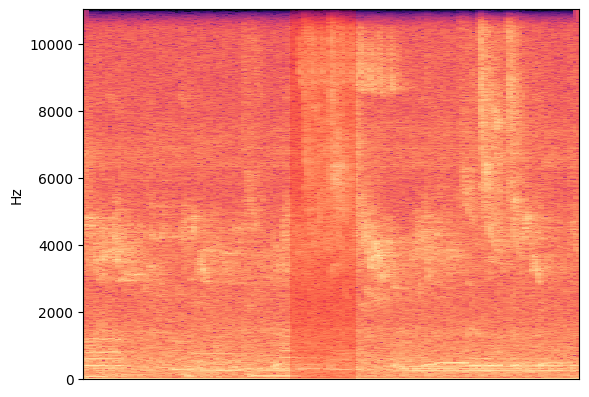

label counts = [0 0 0 6]


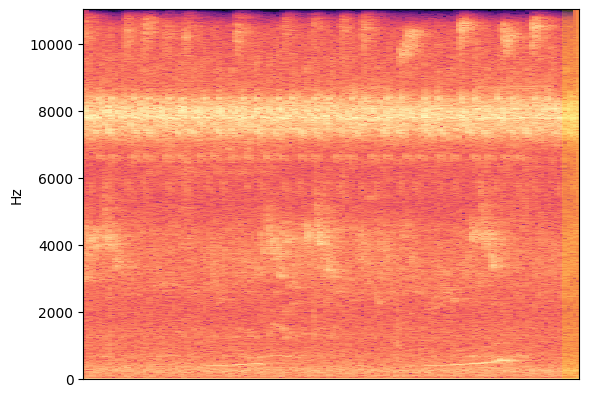

label counts = [0 0 0 3]
failure
label counts = [2 0 0 0]
failure
label counts = [0 0 5 0]


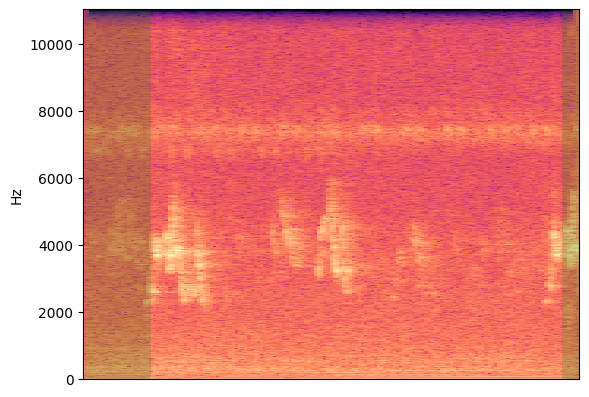

label counts = [4 0 0 0]


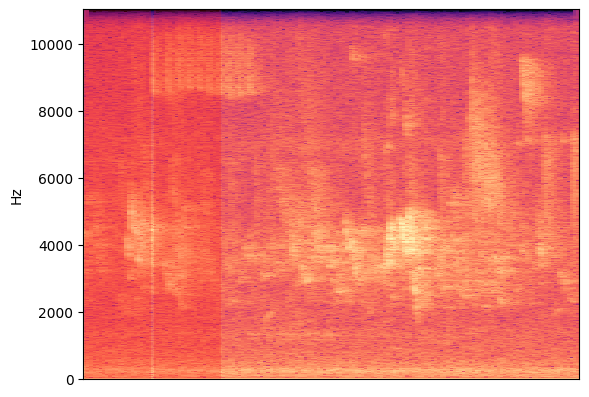

label counts = [3 0 0 0]
failure
label counts = [1 0 0 0]
failure
label counts = [ 0 10  0  0]


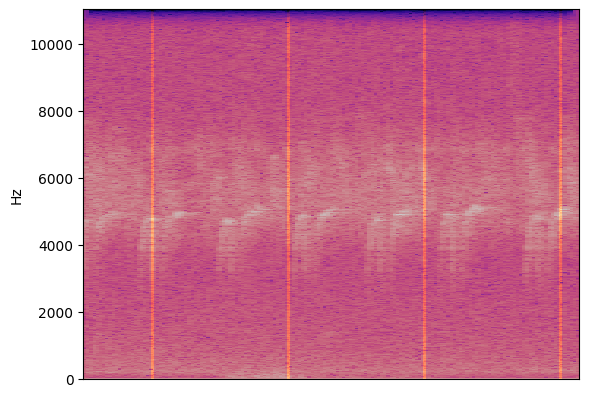

label counts = [4 0 0 0]


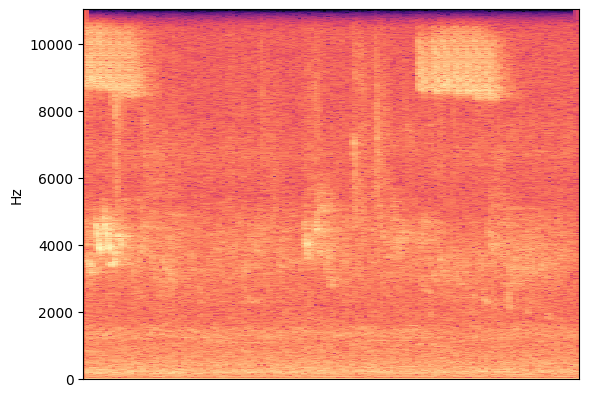

label counts = [4 0 0 0]
failure
label counts = [0 4 0 0]


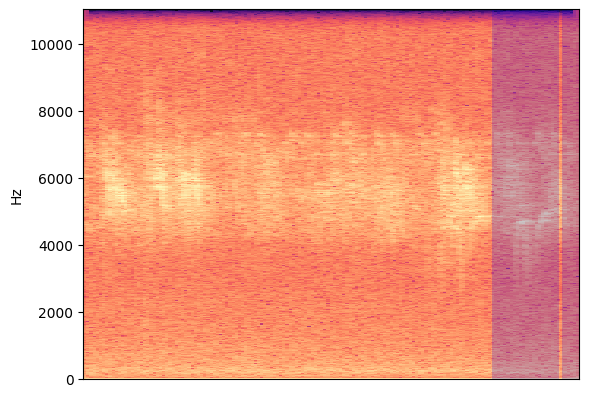

label counts = [4 0 0 0]
failure
label counts = [0 6 0 0]


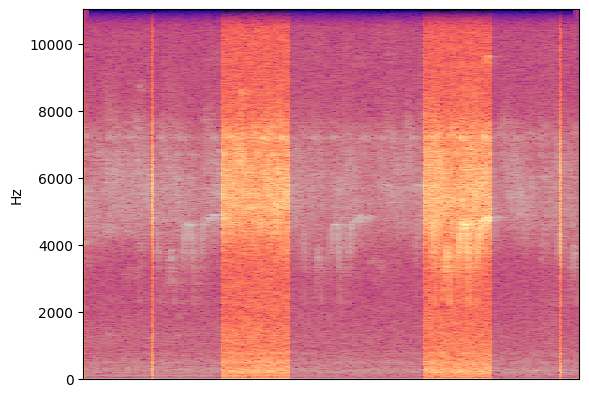

label counts = [3 0 0 0]
failure
label counts = [2 0 0 0]
failure
label counts = [3 0 0 0]


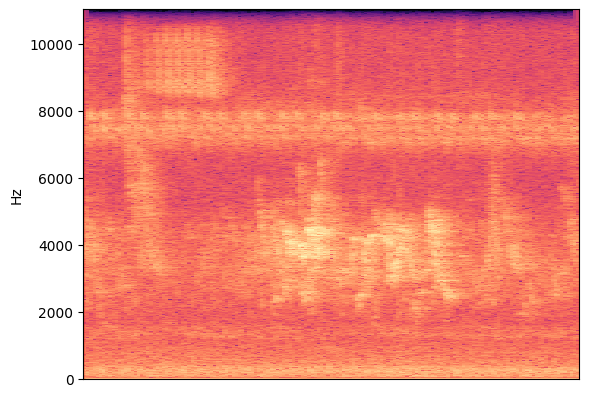

label counts = [0 0 0 6]


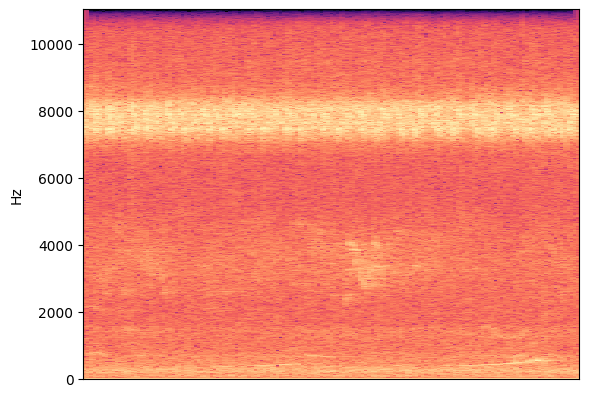

label counts = [3 0 0 0]


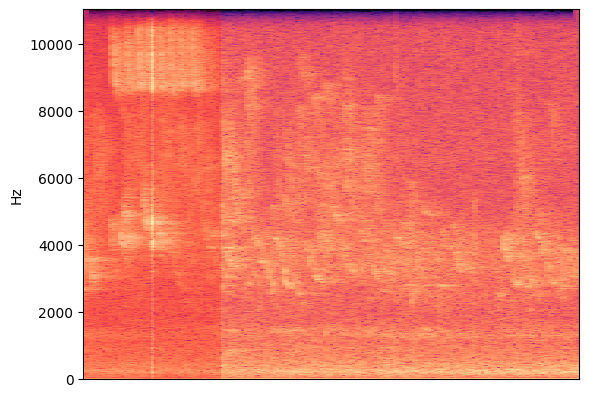

label counts = [3 0 0 0]
failure
label counts = [ 0 10  0  0]


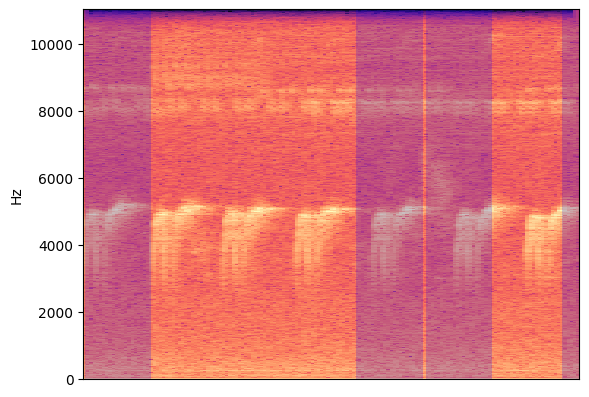

label counts = [0 0 2 0]


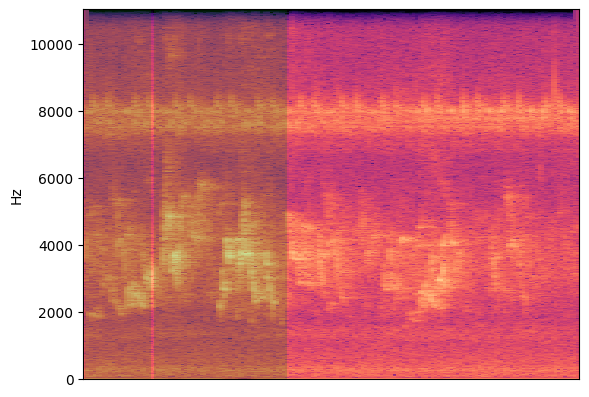

label counts = [ 0 10  0  0]


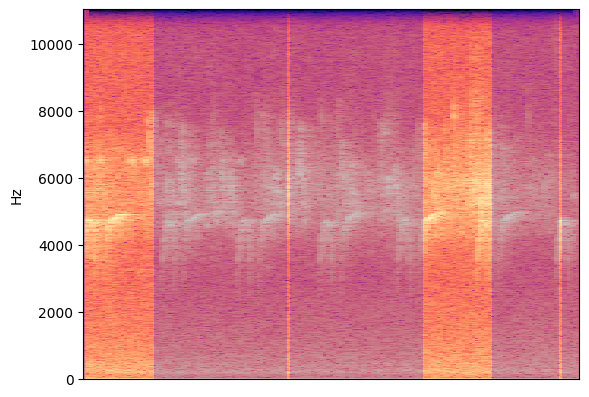

label counts = [0 9 0 0]


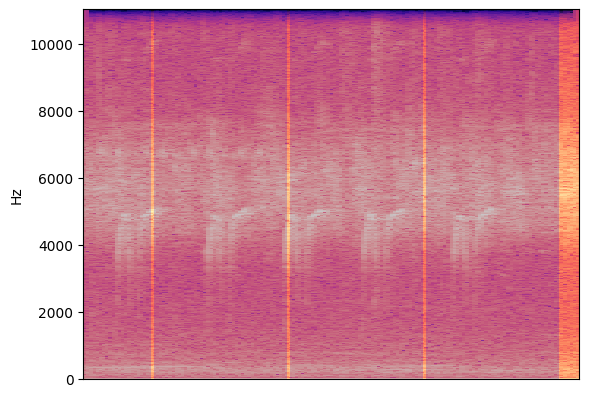

label counts = [ 0 10  0  0]


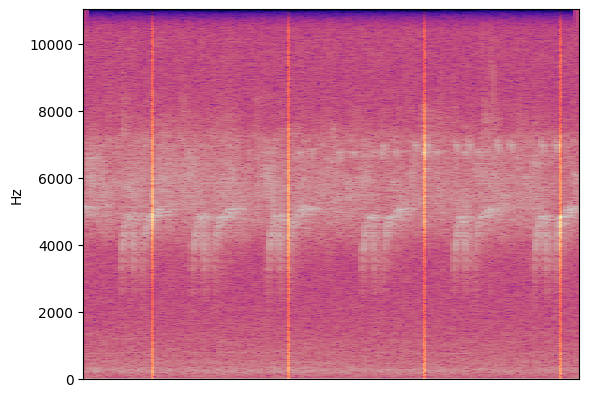

label counts = [4 0 0 0]


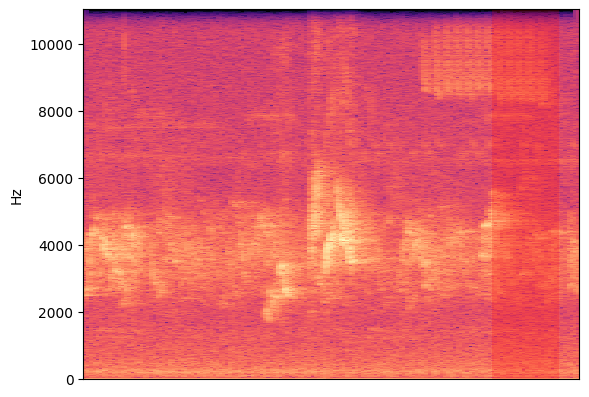

label counts = [3 0 0 0]


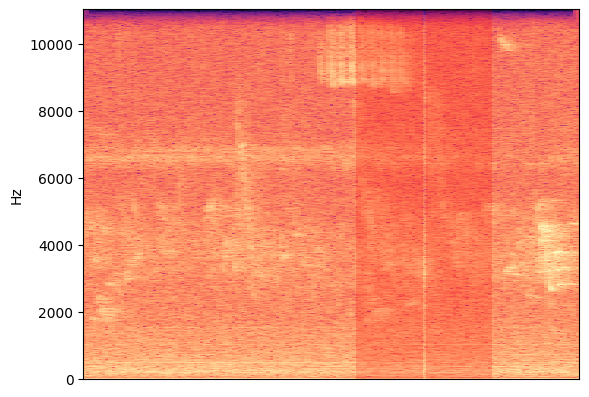

label counts = [0 0 3 0]


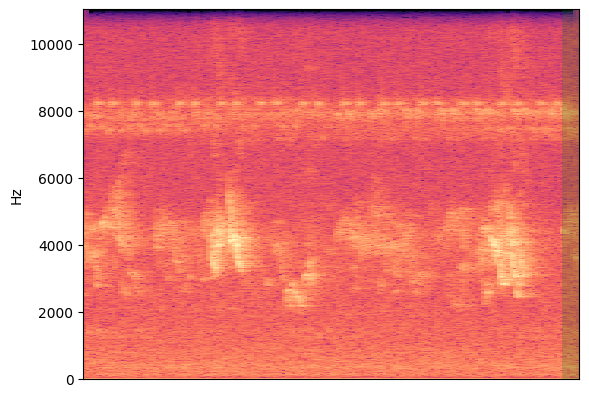

label counts = [0 0 3 0]


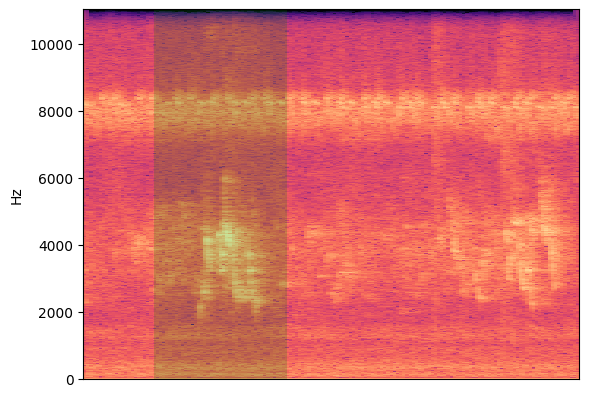

label counts = [0 0 0 4]
failure
label counts = [2 0 0 0]
failure
label counts = [0 8 0 0]


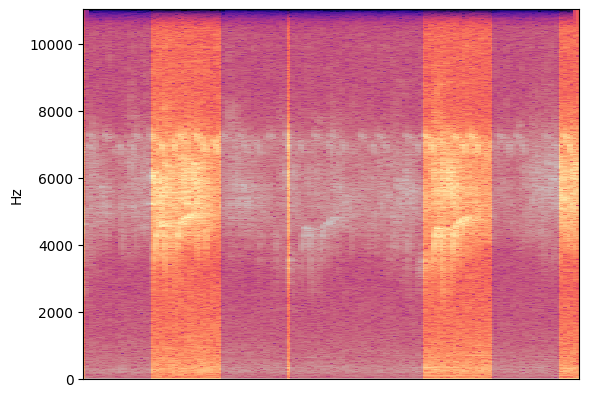

label counts = [0 0 0 3]


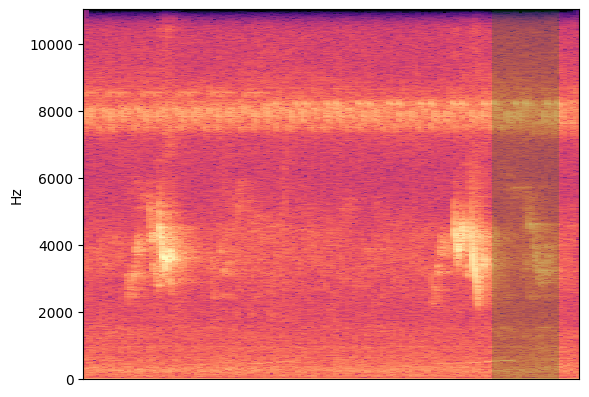

label counts = [4 0 0 0]


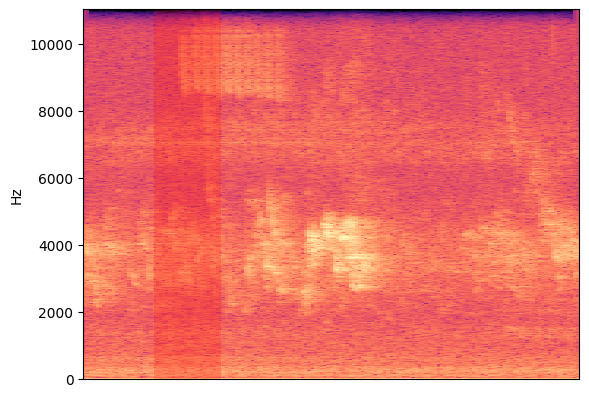

label counts = [0 2 0 0]
failure
label counts = [3 0 0 0]
failure
label counts = [4 0 0 0]
failure
label counts = [0 0 4 0]
failure
label counts = [0 0 3 0]


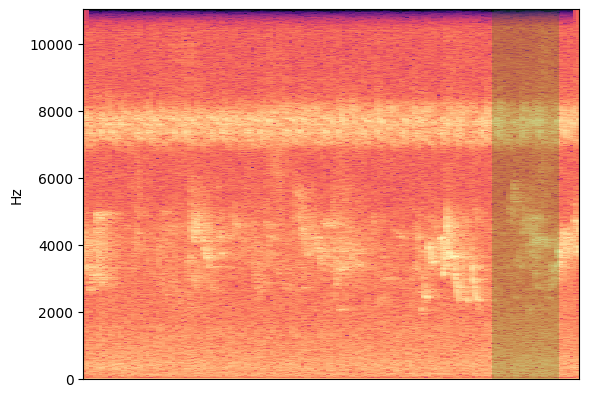

label counts = [0 0 0 2]
failure
label counts = [3 0 0 0]
failure
label counts = [0 9 0 0]


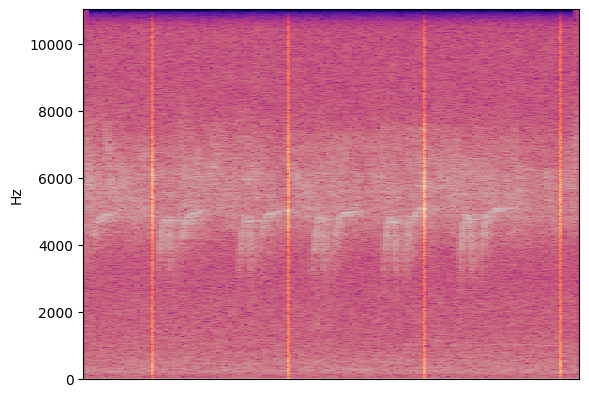

label counts = [0 2 0 0]
failure
label counts = [0 5 0 0]


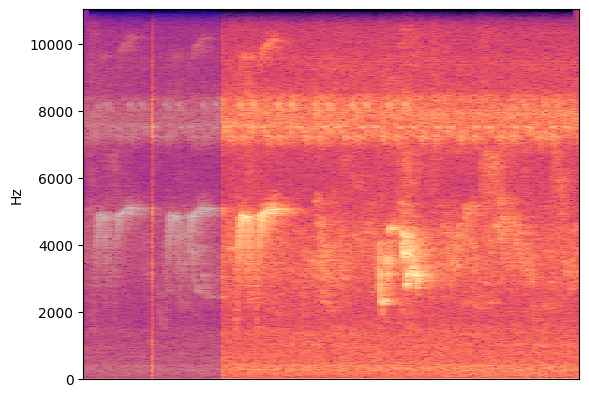

label counts = [0 0 0 8]
failure
label counts = [0 0 2 0]
failure
label counts = [0 0 1 0]
failure
label counts = [3 0 0 0]
failure
label counts = [0 0 0 2]
failure
label counts = [3 0 0 0]
failure
label counts = [ 0 10  0  0]


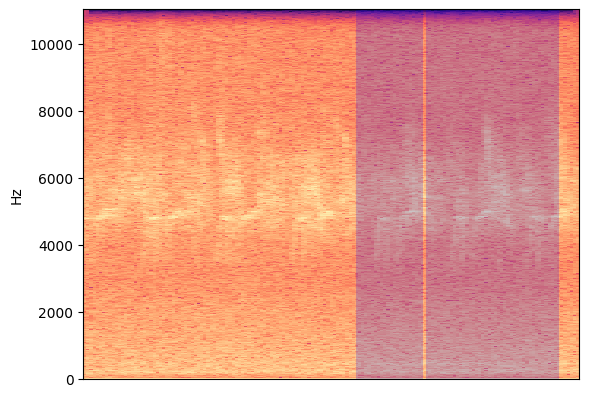

label counts = [3 0 0 0]
failure
label counts = [3 0 0 0]
failure
label counts = [0 0 3 0]


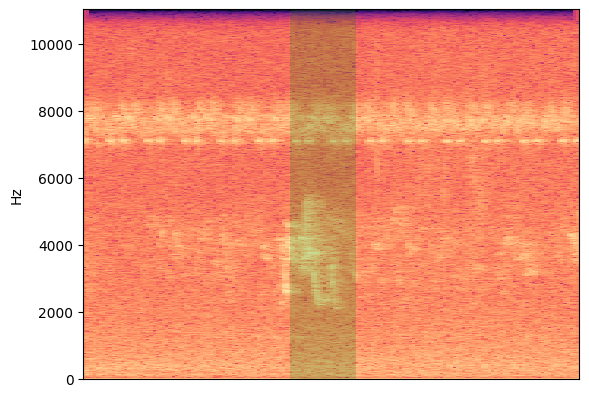

label counts = [0 0 4 0]
failure
label counts = [0 0 3 0]
failure
label counts = [0 0 4 0]
failure
label counts = [0 5 0 0]


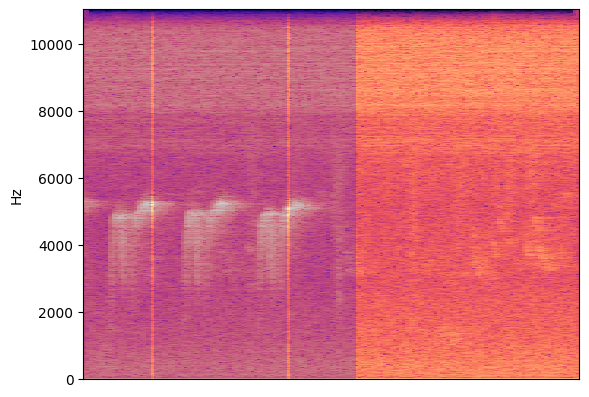

label counts = [4 0 0 0]
failure
label counts = [4 0 0 0]


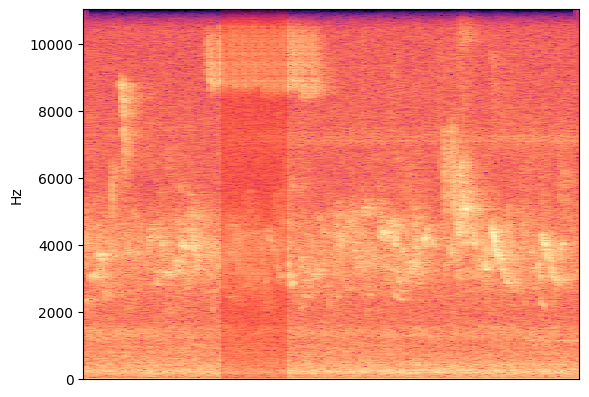

label counts = [0 9 0 0]


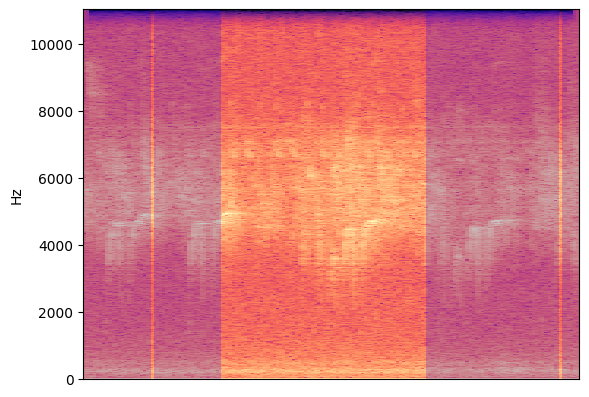

In [27]:
import numpy as np
import librosa
from util import WavDataset
import matplotlib.pyplot as plt
from matplotlib import patches
import soundfile as sf

def read_audio_section(filename, start_time, stop_time):
    track = sf.SoundFile(filename)
    can_seek = track.seekable()
    if not can_seek:
        raise ValueError("Not compatible with seeking")

    sr = track.samplerate
    start_frame = sr * start_time
    frames_to_read = sr * (stop_time - start_time)
    track.seek(start_frame)
    audio_section = track.read(frames_to_read)
    return audio_section, sr

def view_annotations(n=3, T=0.15):
   
    ds = WavDataset()
    for c in RANDOM_CHUNKS[:6000]:
        g = hdf5_dataset[c]
        X, Y = g['X'], g['Y']
        
        start_s = g.attrs['start_time']
        end_s = g.attrs['end_time']
        rec = g.attrs['recording']
        label_counts = g.attrs['classwize_labeled_frame_counts']
        if sum(label_counts) == 0:
            continue # ignore if not annotated
            
        print(f"label counts = {label_counts}")
        
        # spectrogram from wavfile
        y, sr = read_audio_section(ds[rec], start_s, end_s)
        y = librosa.resample(y, orig_sr=sr, target_sr=16_000)
        S = librosa.stft(y)
        S = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S, y_axis='linear')
        
        # predictions for train ds
        X = np.expand_dims(X, axis=0) # for batch dim
        Y_pred = model(X)[0]
        Y_pred = np.array(Y_pred > T)
        if Y_pred.sum() == 0:
            print('failure')
            continue

        row_idx, col_idx = np.where(Y_pred == 1)

        # lines
        frame_hop = 0.5
        for label_idx, row_idx in zip(col_idx, row_idx):
            seconds = frame_hop * row_idx
            spec_frame = librosa.time_to_frames(seconds)
            width = librosa.time_to_frames(0.5)

            colours = ['red', 'blue', 'green', 'yellow']
            rect = patches.Rectangle(
                (spec_frame - width, 0),  
                width, 
                20_000,  # Height
                linewidth=1,
                edgecolor='none',
                facecolor=colours[label_idx],
                alpha=0.2 
            )
            plt.gca().add_patch(rect)

        
        plt.show()
        
view_annotations()


In [ ]:
T